In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

In [4]:
#Importing dataset
df = pd.read_csv('/content/drive/MyDrive/SML_A3/mt.csv')

# Helper functions

In [5]:
#Normalising data
def normalise(x_train, x_val):

  #Calculating mean and std deviation of training data
  x_std = np.std(x_train, axis=0)
  x_mean = np.mean(x_train, axis=0)

  #Normalise training and val datasets using calculated mean and std deviation
  x_train = (x_train - x_mean)/x_std
  x_val = (x_val - x_mean)/x_std

  return x_train, x_val

In [6]:
#R2 score tells us how well regression is being performed
def r2_score(pred, target):
  mse = np.mean(np.square(pred - target))
  var = np.mean(np.square(target - np.mean(target)))
  r2 = 1-(mse/var)

  return r2

In [7]:
#Computing accuracy of classification as proportion of correctly classified samples
def classification_accuracy(pred, target):
  return 1 - (np.sum(abs(pred - target))/len(target))

In [8]:
x = df.drop(['T1', 'T2'], axis=1) #Matrix with samples (2 features per sample)
y_class = df['T1']  #Classification labels
y_reg = df['T2']  #Numerical output (for regression)

#Index denoting 80% of entire dataset
ind = int(0.8*x.shape[0])

#Splitting dataset about 80% mark to get 80/20 training/validation split
x_train = x[0:ind].to_numpy()
x_val = x[ind:].to_numpy()

#Normalising training and validation datasets
x_train, x_val = normalise(x_train, x_val)

#Classification labels converted from 1,2 to 1,0 by subtracting 1 from each of them (easier to work with)
y_class_train = y_class[0:ind].to_numpy() - 1
y_class_val = y_class[ind:].to_numpy() - 1

y_reg_train = y_reg[0:ind].to_numpy()
y_reg_val = y_reg[ind:].to_numpy()

In [9]:
class NeuralNetwork:

  #Initialise hyperparameters, cache dictionaries
  def __init__(self,  max_iterations, num_layers, num_neurons, layer_activation_fns, alpha=0.001, threshold=0.001):
    self.alpha = alpha
    self.threshold = threshold
    self.max_iterations = max_iterations
    self.num_layers = num_layers
    self.layer_activation_fns = layer_activation_fns
    self.num_neurons = num_neurons

    assert len(layer_activation_fns) == num_layers - 1, f"Exactly {num_layers - 1} activation functions must be passed"

    self.weights = {}
    self.Z = {}
    self.layer_outputs = {}
    self.pred_layer_outputs = {}
    self.dA = {}
    self.dZ = {}
    self.cost = []
    self.cost_class = []
    self.cost_reg = []

  #Method to fit training data to NN
  def fit(self, x, y_class, y_reg):

    #Initialise parameters W and b
    for i in range(1,self.num_layers+1):
      self.weights["W" + str(i)] = np.ones((self.num_neurons[i], self.num_neurons[i-1]))
      self.weights["b" + str(i)] = np.zeros((self.num_neurons[i], 1))

    #Iteration counter (used for telling if max iterations reached or not)
    iterations = 0

    while True:
      iterations += 1

      #A0 = Input matrix
      self.layer_outputs["A0"] = x
      self.forwardPropagation(x,y_class,y_reg)  #Make a prediction according to current parameters W and b
      self.backwardPropagation(x,y_class,y_reg) #Update W and b according to prediction error

      #Stop if difference between 2 consecutive costs is less than threshold
      if (len(self.cost) > 2 and abs(self.cost[-1] - self.cost[-2]) < self.threshold):
        break

      #Stop if max iterations reached
      if (iterations >= self.max_iterations):
        break

    #Return prediction matrix (A3)
    return self.layer_outputs["A" + str(self.num_layers)]

  def predict(self, x):

    #A0 = Input matrix
    self.pred_layer_outputs["A0"] = x

    #For each NN layer l,
    #Z[l] = W[l]A[l-1] + b[l]
    #A[l] = g[l](Z[l])
    for i in range(1, self.num_layers+1):
      Z = self.weights["W"+str(i)] @ self.pred_layer_outputs["A"+str(i-1)] + self.weights["b"+str(i)]

      #Last layer activation (not input by user)
      if (i == self.num_layers):
        A = self.ll_activation(Z)

      else:
        #Tanh activation
        if (self.layer_activation_fns[i-1] == "tanh"):
          A = self.tanh(Z)

        #Sigmoid activation
        elif (self.layer_activation_fns[i-1] == "sigmoid"):
          A = self.sigmoid(Z)

      self.pred_layer_outputs["A" + str(i)] = A #Cache A[l]

    #Return prediction matrix, i.e, output of last layer = A3
    return self.pred_layer_outputs["A" + str(self.num_layers)]

  #Sigmoid activation
  def sigmoid(self, x):
    return np.reciprocal(1+np.exp(-x))

  #Tanh activation
  def tanh(self, x):
    return np.tanh(x)

  #Activation function for last layer
  def ll_activation(self, x):

    #classification -> Sigmoid activation @ last layer (Values correspond to probabilities and are thus, bounded between 0 and 1)
    #regression -> Linear activaton @ last layer (Values not bounded)
    r1 = self.sigmoid(x[0,:]).reshape(1,-1)
    r2 = x[1,:].reshape(1,-1)

    x_new = np.concatenate([r1, r2], axis=0)  #Matrix with activation functions applied to data
    return x_new

  #Function to compute prediction cost
  def compute_cost(self, A, y_class, y_reg):

    #1st row of A3 -> classification output
    #2nd row of A3 -> regression output
    yhat_class = A[0,:]
    yhat_reg = A[1,:]

    cost_class = -(y_class*np.log(yhat_class) + (1-y_class)*np.log(1-yhat_class)) #Log loss for classification
    cost_reg = (1/2)*np.square(y_reg-yhat_reg)  #MSE for regression

    self.cost.append(np.mean(cost_class) + np.mean(cost_reg)) #total cost = mean classification cost + mean regression cost
    self.cost_class.append(np.mean(cost_class))
    self.cost_reg.append(np.mean(cost_reg))

    #Return cost matrix
    A_new = np.concatenate([cost_class, cost_reg], axis=0)
    return A_new

  def forwardPropagation(self, x, y_class, y_reg):
    yhat_class = 0
    yhat_reg = 0

    #For each NN layer l,
    #Z[l] = W[l]A[l-1] + b[l]
    #A[l] = g[l](Z[l])
    for i in range(1, self.num_layers+1):

      #Calcualting Z
      Z = self.weights["W"+str(i)] @ self.layer_outputs["A"+str(i-1)] + self.weights["b"+str(i)]
      self.Z["Z" + str(i)] = Z

      #Calculating A according to current layer (activation function different for different layers)
      if (i == self.num_layers):
        A = self.ll_activation(Z)
        self.layer_outputs["A" + str(i)] = A

      else:

        if (self.layer_activation_fns[i-1] == "tanh"):
          A = self.tanh(Z)

        elif (self.layer_activation_fns[i-1] == "sigmoid"):
          A = self.sigmoid(Z)

        self.layer_outputs["A" + str(i)] = A


    #Compute prediction cost and store in cost array
    self.compute_cost(self.layer_outputs["A" + str(self.num_layers)], y_class, y_reg)

  #Update parameters W and b
  def backwardPropagation(self, x, y_class, y_reg):

    #Split output into classification and regression outputs
    A_ll = self.layer_outputs["A" + str(self.num_layers)]
    yhat_class = A_ll[0, :].reshape(1,-1)
    yhat_reg = A_ll[1, :].reshape(1,-1)

    #Derivative of log loss
    dA_ll_logloss = -(y_class/yhat_class) + ((1-y_class)/(1 - yhat_class))

    #Derivative of mse
    dA_ll_mse = yhat_reg - y_reg
    dA_ll = np.concatenate([dA_ll_logloss, dA_ll_mse], axis=0)
    self.dA["dA" + str(self.num_layers)] = dA_ll

    for i in range(self.num_layers, 0, -1):

      if (i==self.num_layers):
        #Layer 3
        g_ll_diff_class = (yhat_class*(1-yhat_class)).reshape(1,-1)  #Derivate of sigmoid(Z3) = A3(1-A3) = yhat(1-yhat)
        g_ll_diff_reg = np.ones(yhat_reg.shape).reshape(1,-1)  #Derivative of linear function is 1
        self.dZ["dZ" + str(i)] = dA_ll * np.concatenate([g_ll_diff_class, g_ll_diff_reg], axis=0)

      else:

        if (self.layer_activation_fns[i-1] == "sigmoid"):
          g_diff = self.layer_outputs["A" + str(i)] * (1-self.layer_outputs["A" + str(i)])
          self.dZ["dZ" + str(i)] = (self.weights["W" + str(i+1)].T @ self.dZ["dZ" + str(i+1)]) * (g_diff)

        elif (self.layer_activation_fns[i-1] == "tanh"):
          g_diff = 1-np.square(self.tanh(self.Z["Z" + str(i)]))
          self.dZ["dZ" + str(i)] = (self.weights["W" + str(i+1)].T @ self.dZ["dZ" + str(i+1)]) * (g_diff)

      dZ = self.dZ["dZ" + str(i)]
      dW = (dZ @ self.layer_outputs["A" + str(i-1)].T)
      db = np.sum(dZ, axis=1, keepdims=True)
      self.weights["W" + str(i)] -= self.alpha*dW
      self.weights["b" + str(i)] -= self.alpha*db

In [19]:
#Hyperparameters
max_iterations = 500
learning_rate = 0.001
threshold = 0.001
num_layers = 3  # Does not include input layer
num_neurons = [2,4,4,2] #Number of neurons in each layer order-wise
layer_activation_fns = ["tanh", "sigmoid"]  #Activation function of each hidden layer in order

In [20]:
#Create instance of neural network, fit with training data and make predictions using validation data
nn = NeuralNetwork(max_iterations, num_layers, num_neurons, layer_activation_fns, alpha=learning_rate, threshold=threshold)
y_pred_train = nn.fit(x_train.T, y_class_train.reshape(1,-1), y_reg_train.reshape(1,-1))
y_pred_val = nn.predict(x_val.T)

#Split regression and classification predictions - training
y_pred_train_class = (y_pred_train[0,:] >= 0.5).astype(int)
y_pred_train_reg = y_pred_train[1,:]

#Split regression and classification predictions - validation
y_pred_val_class = (y_pred_val[0,:] >= 0.5).astype(int)
y_pred_val_reg = y_pred_val[1,:]

#Training Accuracy
accuracy_train_class = classification_accuracy(y_pred_train_class, y_class_train)
r2_train = r2_score(y_pred_train_reg, y_reg_train)

print("Training accuracy for classification:", accuracy_train_class)
print("Training R2 score for regression:", r2_train)

#Validation Accuracy
accuracy_val_class = classification_accuracy(y_pred_val_class, y_class_val)
r2_val = r2_score(y_pred_val_reg, y_reg_val)

print("Validation accuracy for classification:", accuracy_val_class)
print("Validation R2 score for regression:", r2_val)

Training accuracy for classification: 0.975
Training R2 score for regression: 0.9712041992163881
Validation accuracy for classification: 1.0
Validation R2 score for regression: 0.723742056420074


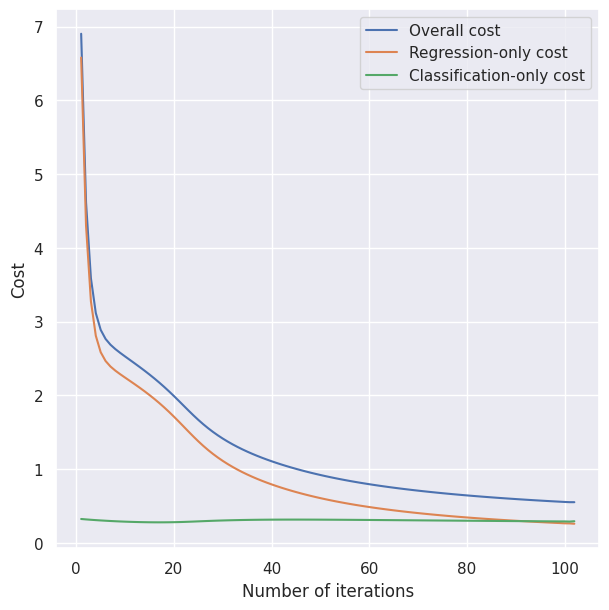

In [21]:
plt.figure(figsize=(7,7))
#Visualising overall cost trend
overall_cost = {
'Number of iterations' : np.arange(1, len(nn.cost) + 1),
'Cost' : np.array(nn.cost)
}
overall_cost_df = pd.DataFrame(overall_cost)
sns.lineplot(data=overall_cost_df, x='Number of iterations', y='Cost', label='Overall cost')

#Visualising regression-only cost
cost_reg = {
    'Number of iterations' : np.arange(1, len(nn.cost_reg) + 1),
    'Cost' : np.array(nn.cost_reg)
}
cost_reg_df = pd.DataFrame(cost_reg)
sns.lineplot(data=cost_reg_df, x='Number of iterations', y='Cost', label='Regression-only cost')

#visualising classification-only cost
cost_class = {
    'Number of iterations' : np.arange(1, len(nn.cost_class) + 1),
    'Cost' : np.array(nn.cost_class)
}
cost_class_df = pd.DataFrame(cost_class)
sns.lineplot(data=cost_class_df, x='Number of iterations', y='Cost', label='Classification-only cost')

plt.legend()